## TODO:
- add noise to label to add diversity

In [8]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import models
import utils
import glob
import visualize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def pre_process(img):
    return img * 2 - 1

def post_process(img):
    return (img + 1) / 2

def sample_noise(batch_size, dim):
    return np.random.uniform(-1, 1, size=(batch_size, dim))


'''
def add_label_noise(inputs):
    # add noise to label
    # TODO: Can this be faster?
    noise_label_false = np.random.uniform(0.0, 0.2, size=inputs.shape)
    noise_label_true = np.random.uniform(-0.1, 0.1, size=inputs.shape)
    inputs = inputs.astype(np.float32)
    inputs[np.where(inputs != 1)] = noise_label_false[np.where(inputs != 1)]
    inputs[np.where(inputs == 1)] += noise_label_true[np.where(inputs == 1)]
    return inputs
'''
def add_label_noise(inputs):
    return inputs

# Build specific format t to show out
formal_t = np.zeros((100, 10))
for i in range(10):
    formal_t[i*10:i*10+10, i] += 1


In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./dataset/MNIST_data', one_hot=True)

batch_size = 64

Extracting ./dataset/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-labels-idx1-ubyte.gz


In [11]:
def run_a_gan(sess, G_train_step, G_loss, C_train_step, C_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10, n_critic=5):
    
    max_iter = mnist.train.num_examples*num_epoch // (batch_size * n_critic)
    for it in range(max_iter):
        if it % show_every == 0:
            noise_z = sample_noise(100, noise_dim)
            samples = sess.run(G_sample, feed_dict={z:noise_z, t: add_label_noise(formal_t)})
            fig = visualize.show_images(samples, post_process=post_process)
            plt.show()
            print()
        
        for i in range(n_critic):
            noise_z = sample_noise(batch_size, noise_dim)
            minibatch, mini_t = mnist.train.next_batch(batch_size)
            minibatch = np.reshape(minibatch, [-1, 28, 28, 1])
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: pre_process(minibatch), z: noise_z, t: add_label_noise(mini_t)})
        
        noise_z = sample_noise(batch_size, noise_dim)   
        _, G_loss_curr = sess.run([G_train_step, G_loss,], feed_dict={z:noise_z, t: mini_t})
        _, C_loss_curr = sess.run([C_train_step, C_loss], feed_dict={x:pre_process(minibatch), z: noise_z, t:add_label_noise(mini_t)})
        
        if it % print_every == 0:
            print('Iter: {0}/{1}, D: {2:.4}, G: {3:.4}, C: {4:.4}'.format(it, max_iter, D_loss_curr, G_loss_curr, C_loss_curr))
    print('Final images')
    noise_z = sample_noise(100, noise_dim)
    samples = sess.run(G_sample, feed_dict={z:noise_z, t: add_label_noise(formal_t)})
    
    fig = visualize.show_images(samples, final="AC-GAN(no condition embedding)", post_process=post_process)
    plt.show()

In [12]:
tf.reset_default_graph()

noise_dim = 100

x = tf.placeholder(tf.float32, [None, 28, 28, 1])
z = tf.placeholder(tf.float32, [None, noise_dim])
t = tf.placeholder(tf.float32, [None, 10])

generator = models.generator_AC_GAN
classifier = models.classifier_AC_GAN
discriminator = models.discriminator_AC_GAN

G_sample = generator(z, t, reuse=False)
logits_real = discriminator(x, reuse=False)
logits_fake = discriminator(G_sample, reuse=True)
class_real = classifier(x, reuse=False)
class_fake = classifier(G_sample, reuse=True)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
C_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'classifier')
C_vars += (D_vars + G_vars)

In [13]:
def wgangp_loss(logits_real, class_real, logits_fake, class_fake, batch_size, x, G_sample):
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    shape = tf.concat((tf.shape(x)[0:1], tf.tile([1], [x.shape.ndims - 1])), axis=0)
    eps = tf.random_uniform(shape=shape, minval=0., maxval=1.)
    x_hat = x + eps * (G_sample - x)
    
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        pred = discriminator(x_hat)
        grad_D_x_hat = tf.gradients(pred, x)[0]
        
    #grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=1))
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=tf.range(1, x.shape.ndims)))
    grad_pen = lam * tf.reduce_mean((grad_norm - 1.) ** 2)
    
    D_loss = D_loss + grad_pen
    C_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(t, logits=class_real)) + tf.reduce_mean(tf.losses.softmax_cross_entropy(t, logits=class_fake))
    
    return D_loss, C_loss, G_loss

D_loss, C_loss, G_loss  =wgangp_loss(logits_real, class_real, logits_fake, class_fake, batch_size, x, G_sample)
D_train_step = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5).minimize(D_loss, var_list=D_vars)
C_train_step = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5).minimize(C_loss, var_list=C_vars)
G_train_step = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5).minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

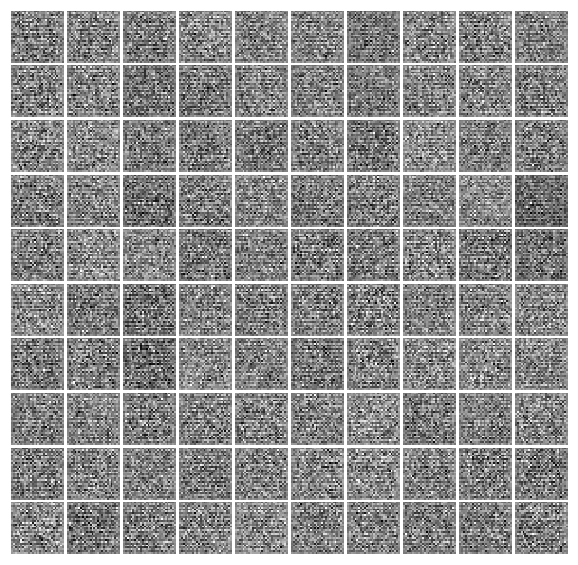


Iter: 0/4296, D: -19.97, G: 2.254, C: 4.598
Iter: 50/4296, D: -16.94, G: -1.362, C: 0.3627
Iter: 100/4296, D: -19.43, G: 21.69, C: 0.4522
Iter: 150/4296, D: -18.31, G: 25.33, C: 0.2958
Iter: 200/4296, D: -19.34, G: 35.66, C: 0.129


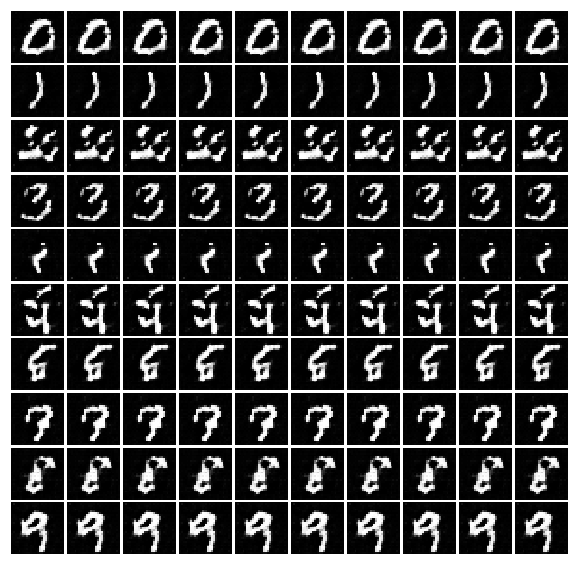


Iter: 250/4296, D: -18.05, G: 35.21, C: 0.299
Iter: 300/4296, D: -20.47, G: 30.04, C: 0.2067
Iter: 350/4296, D: -16.89, G: 32.66, C: 0.1614
Iter: 400/4296, D: -11.43, G: 17.39, C: 0.2205
Iter: 450/4296, D: -12.69, G: 19.33, C: 0.4275


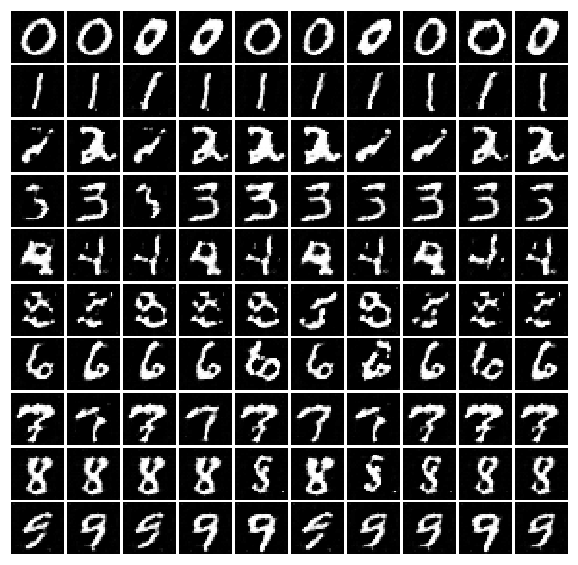


Iter: 500/4296, D: -11.6, G: 21.26, C: 0.1703
Iter: 550/4296, D: -7.962, G: 15.12, C: 0.3802
Iter: 600/4296, D: -7.008, G: 11.6, C: 0.3079
Iter: 650/4296, D: -13.94, G: 12.68, C: 0.05294
Iter: 700/4296, D: -14.62, G: 9.004, C: 0.2859


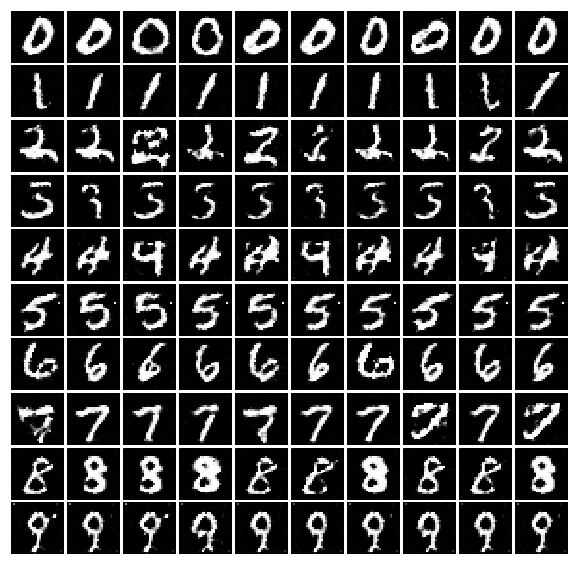


Iter: 750/4296, D: -13.42, G: 5.226, C: 0.04982
Iter: 800/4296, D: -9.709, G: -2.597, C: 0.2016
Iter: 850/4296, D: -10.6, G: 0.07902, C: 0.0599
Iter: 900/4296, D: -13.2, G: 5.738, C: 0.09074
Iter: 950/4296, D: -6.04, G: -3.491, C: 0.17


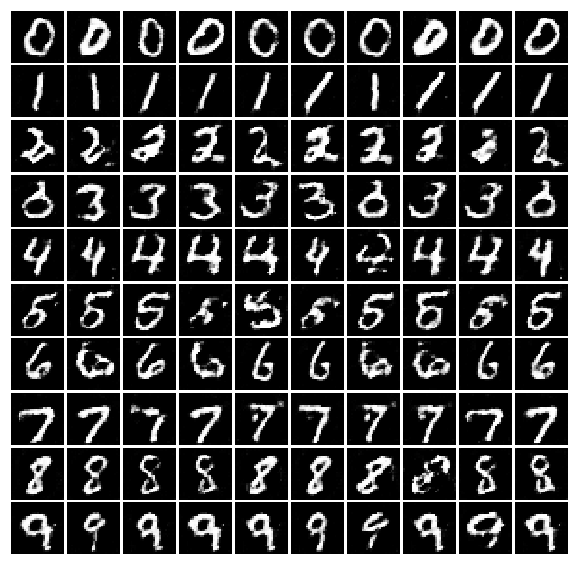


Iter: 1000/4296, D: -4.868, G: -1.79, C: 0.06594
Iter: 1050/4296, D: -4.568, G: -5.645, C: 0.03236
Iter: 1100/4296, D: -4.053, G: -5.63, C: 0.2168
Iter: 1150/4296, D: -8.257, G: -6.571, C: 0.04431
Iter: 1200/4296, D: -3.654, G: -5.568, C: 0.1665


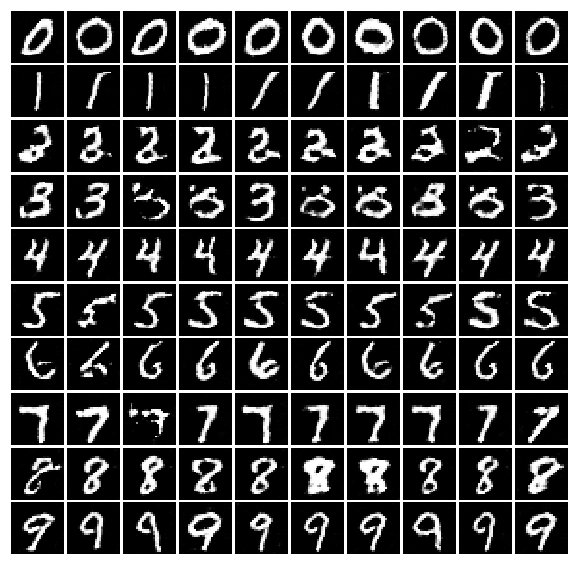


Iter: 1250/4296, D: -11.95, G: -16.37, C: 0.03246
Iter: 1300/4296, D: -3.974, G: -6.255, C: 0.09919
Iter: 1350/4296, D: 0.17, G: -10.43, C: 0.07736
Iter: 1400/4296, D: -1.88, G: -5.208, C: 0.1685
Iter: 1450/4296, D: -2.707, G: -13.46, C: 0.03605


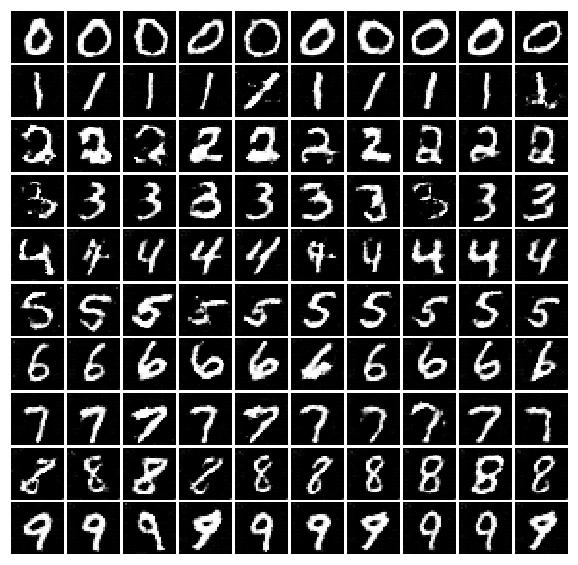


Iter: 1500/4296, D: -3.808, G: -11.31, C: 0.03162
Iter: 1550/4296, D: -3.966, G: -17.02, C: 0.1047
Iter: 1600/4296, D: -4.456, G: -17.67, C: 0.1641
Iter: 1650/4296, D: -1.956, G: -17.78, C: 0.01907
Iter: 1700/4296, D: -4.907, G: -13.95, C: 0.113


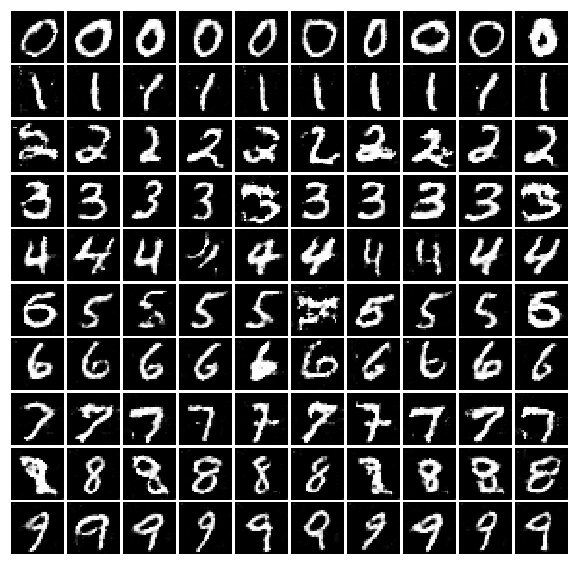


Iter: 1750/4296, D: -1.461, G: -12.29, C: 0.2511
Iter: 1800/4296, D: -5.237, G: -14.09, C: 0.03027
Iter: 1850/4296, D: -1.488, G: -13.47, C: 0.04583
Iter: 1900/4296, D: -4.478, G: -9.197, C: 0.0188
Iter: 1950/4296, D: -2.49, G: -9.348, C: 0.1055


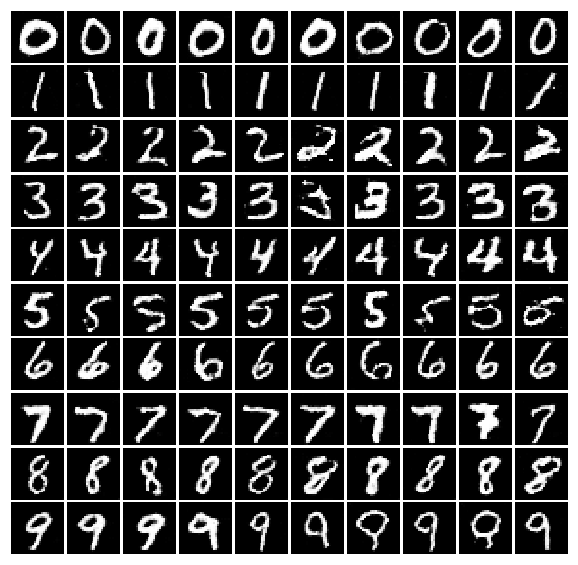


Iter: 2000/4296, D: -5.675, G: -26.1, C: 0.07495
Iter: 2050/4296, D: -2.793, G: -10.86, C: 0.07062
Iter: 2100/4296, D: -1.061, G: -16.82, C: 0.1756
Iter: 2150/4296, D: 0.4842, G: -13.05, C: 0.1527
Iter: 2200/4296, D: -1.698, G: -12.92, C: 0.04314


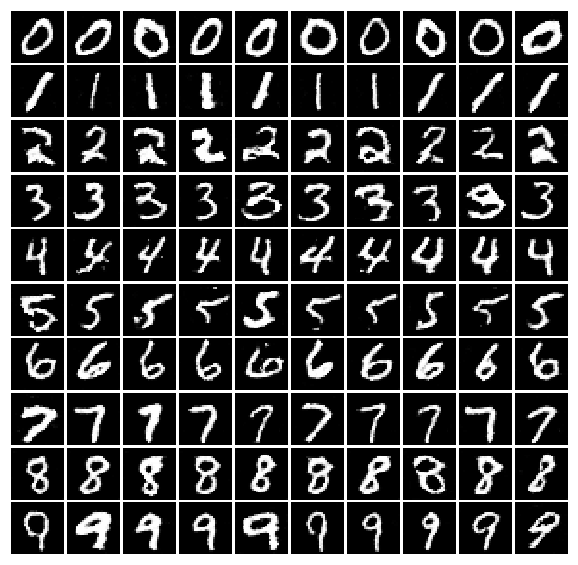


Iter: 2250/4296, D: -5.304, G: -28.67, C: 0.1627
Iter: 2300/4296, D: -2.758, G: -8.701, C: 0.06781
Iter: 2350/4296, D: 19.68, G: -3.646, C: 0.0298
Iter: 2400/4296, D: -0.009878, G: -13.66, C: 0.1361
Iter: 2450/4296, D: -0.5069, G: -15.64, C: 0.09271


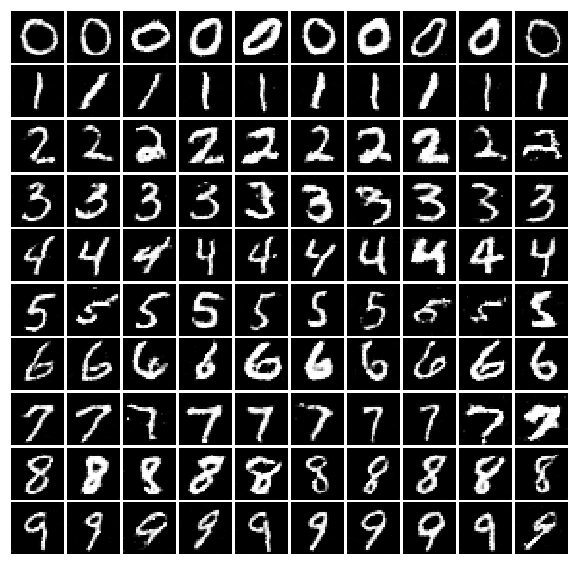


Iter: 2500/4296, D: -7.802, G: -31.21, C: 0.05708
Iter: 2550/4296, D: -0.998, G: -7.055, C: 0.05178
Iter: 2600/4296, D: -0.1919, G: -17.0, C: 0.06514
Iter: 2650/4296, D: -4.139, G: -24.41, C: 0.01344
Iter: 2700/4296, D: -3.132, G: -28.3, C: 0.08494


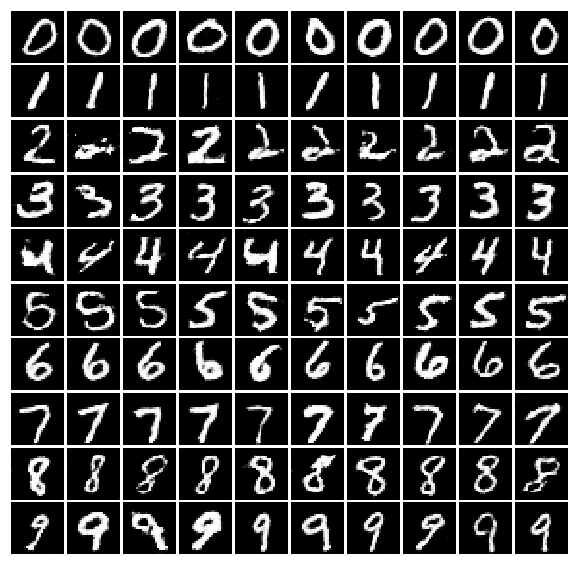


Iter: 2750/4296, D: 0.9254, G: -9.391, C: 0.01933
Iter: 2800/4296, D: -3.792, G: -19.57, C: 0.1045
Iter: 2850/4296, D: -4.871, G: -17.85, C: 0.05544
Iter: 2900/4296, D: -4.669, G: -17.02, C: 0.05289
Iter: 2950/4296, D: -2.351, G: -11.33, C: 0.1324


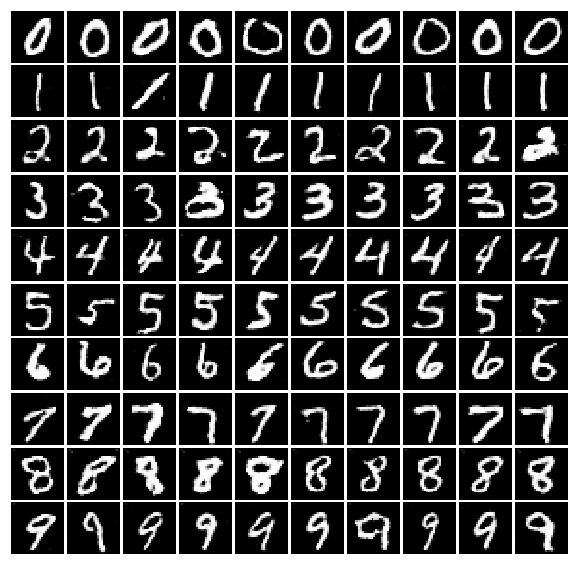


Iter: 3000/4296, D: -0.8907, G: -12.17, C: 0.05436
Iter: 3050/4296, D: -2.644, G: -18.77, C: 0.02522
Iter: 3100/4296, D: -0.6903, G: -15.02, C: 0.0304
Iter: 3150/4296, D: -1.609, G: -12.82, C: 0.02525
Iter: 3200/4296, D: -3.756, G: -17.73, C: 0.07088


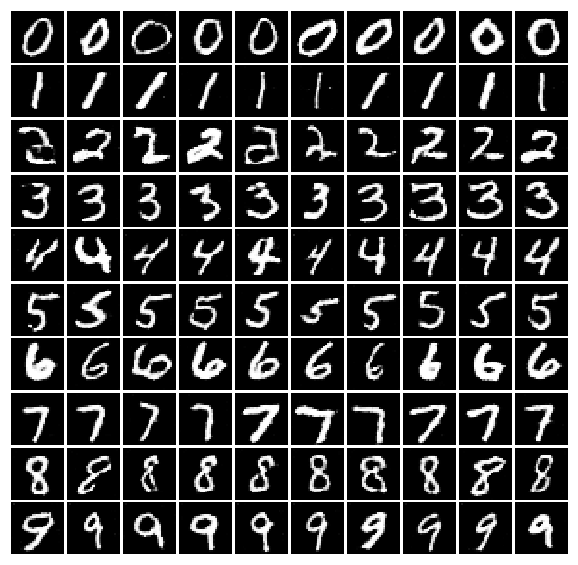


Iter: 3250/4296, D: -0.2337, G: -16.37, C: 0.02684
Iter: 3300/4296, D: -9.061, G: -29.52, C: 0.05482
Iter: 3350/4296, D: -6.487, G: -23.97, C: 0.04739
Iter: 3400/4296, D: -5.735, G: -18.85, C: 0.02963
Iter: 3450/4296, D: -7.181, G: -32.65, C: 0.03878


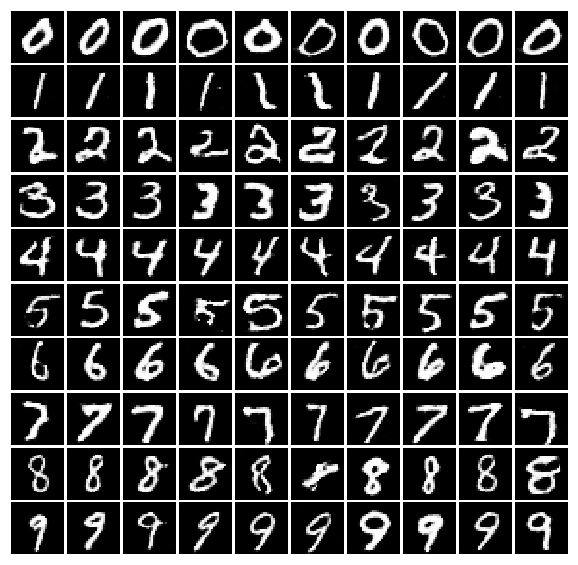


Iter: 3500/4296, D: 0.08063, G: -18.42, C: 0.3255
Iter: 3550/4296, D: -1.65, G: -17.9, C: 0.01495
Iter: 3600/4296, D: -1.997, G: -15.12, C: 0.126
Iter: 3650/4296, D: -0.3562, G: -16.36, C: 0.08719
Iter: 3700/4296, D: -2.42, G: -18.05, C: 0.198


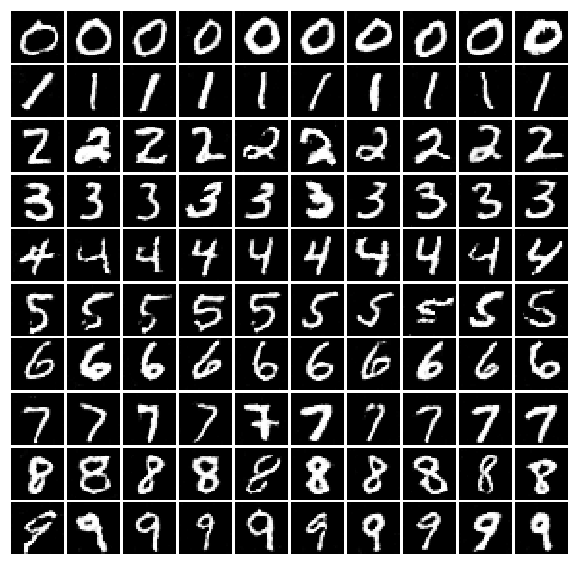


Iter: 3750/4296, D: -2.799, G: -7.963, C: 0.07577
Iter: 3800/4296, D: -0.563, G: -11.42, C: 0.05738
Iter: 3850/4296, D: -1.858, G: -16.39, C: 0.02559
Iter: 3900/4296, D: -9.454, G: -26.19, C: 0.01102
Iter: 3950/4296, D: -2.187, G: -16.52, C: 0.09772


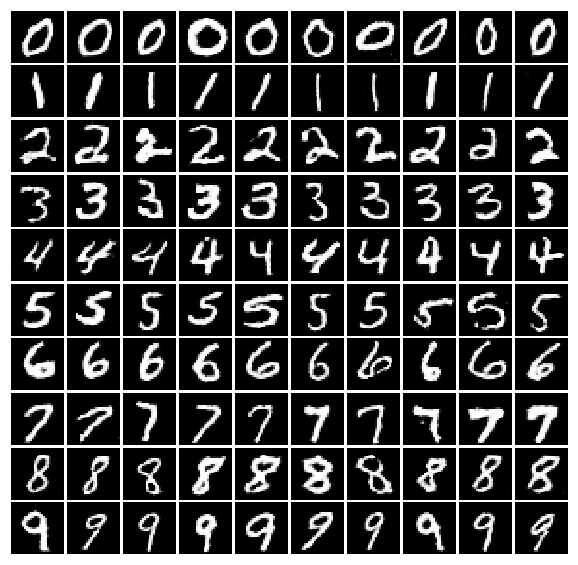


Iter: 4000/4296, D: -0.03199, G: -12.04, C: 0.1143
Iter: 4050/4296, D: -1.444, G: -6.156, C: 0.01963
Iter: 4100/4296, D: -10.79, G: -26.49, C: 0.01648
Iter: 4150/4296, D: -7.226, G: -12.73, C: 0.05476
Iter: 4200/4296, D: -7.676, G: -35.04, C: 0.08837


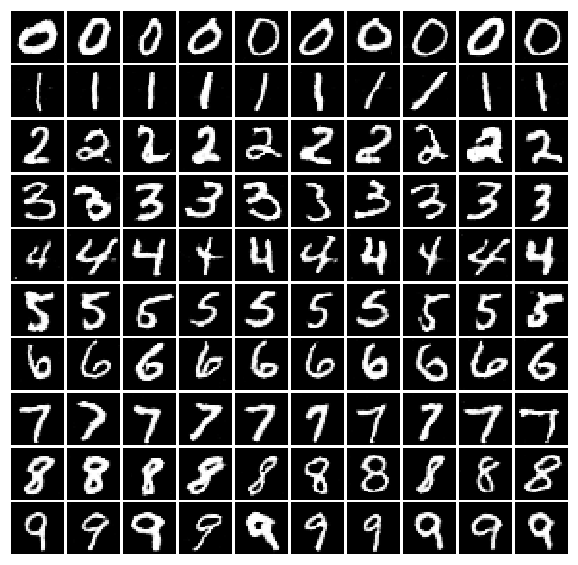


Iter: 4250/4296, D: -5.148, G: -23.64, C: 0.04867
Final images


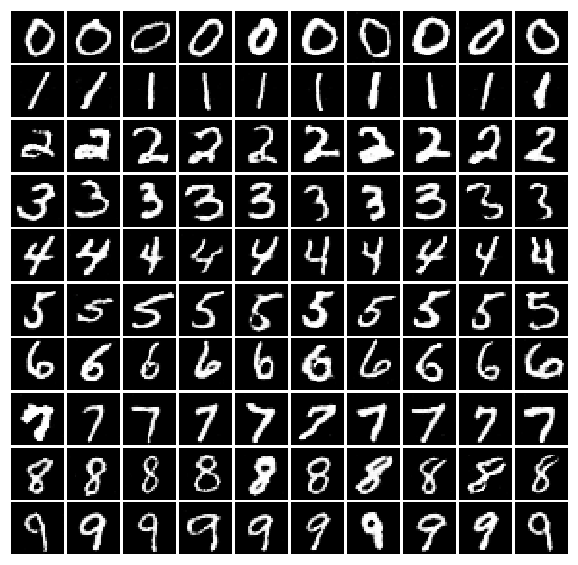

In [14]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, C_train_step, C_loss, D_train_step, D_loss, G_extra_step, D_extra_step, batch_size=batch_size, num_epoch=25, n_critic=5)